In [1]:
import numpy as np
import cPickle as pickle

from best.abstraction import Abstraction
from best.mdp import ParallelMDP
import rss18_functions as rf

with open("policies.pickle", "rb") as input_file:
    copter_policy, rover_policy, prob = pickle.load(input_file)

Using numpy backend.


mapstate: [1, 3, 3, 2, 2]
mapstate: [1, 3, 1, 3, 2]
mapstate: [3, 4, 3, 1, 3]
mapstate: [1, 3, 3, 2, 2]


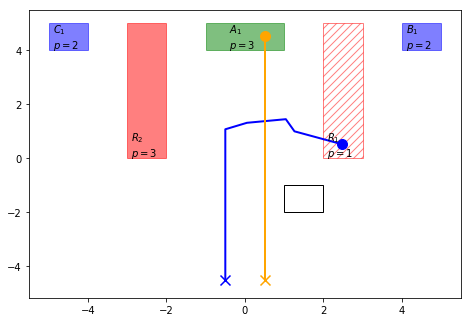

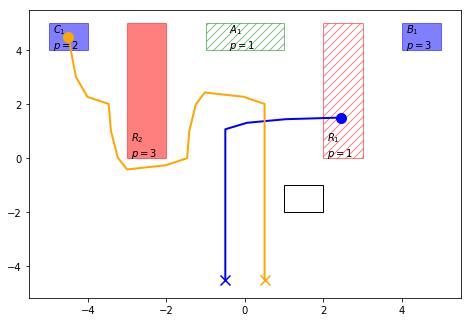

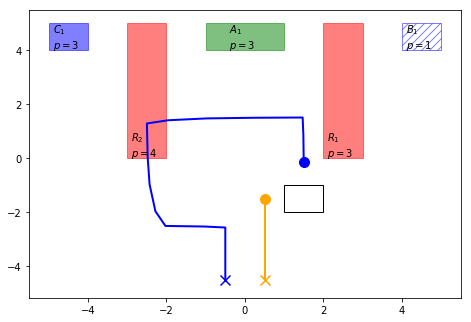

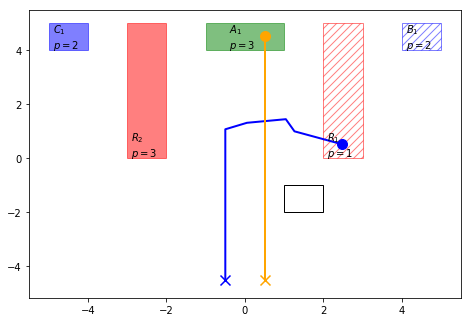

In [5]:
# Simulations

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from best import midx_to_idx

conn_copt_env = rf.get_conn_copt_env(prob['regs'], prob['cop_sight'])
conn_rov_env = rf.get_conn_rov_env(prob['regs'])
conn_ltl = rf.get_ltl_connection(prob['regs'])

realmaps = ([0, 4, 4, 4, 4], [0, 4, 0, 4, 4], [4, 4, 4, 0, 4], [0, 4, 4, 0, 4])   # true map state

for exp_i in range(len(realmaps)):
    
    realmap = realmaps[exp_i][:]
    
    mapstate = prob['env_x0'][:]
    
    rover_policy.reset()
    copter_policy.reset()

    # copter simulation
    x_copter = prob['cop_x0'].reshape((1,3))
    it = 0
    while not copter_policy.finished() and it < 800:

        x_curr = x_copter[-1, :].flatten()

        map_meas = list(conn_copt_env(x_curr))[0]

        for i in range(len(map_meas)):
            if mapstate[i] in [0, 4]:
                continue
            if map_meas[i] == 1:  # weak meas
                if realmap[i] == 4:
                    mapstate[i] = 3
                else:
                    mapstate[i] = 1
            if map_meas[i] == 2:
                mapstate[i] = realmap[i]

        x_map = midx_to_idx(mapstate, [5,] * len(prob['regs']))
                
        x_next, _ = copter_policy(x_curr, x_map)
        
        x_del = x_curr + 0.1*(x_next - x_curr)/np.linalg.norm(x_next - x_curr)
        x_copter = np.vstack([x_copter, x_del])
        it += 1
        
    print 'mapstate: {}'.format(mapstate)
        
    mid_probs = mapstate[:]

    # rover simulation
    it = 0
    x_rover = prob['rov_x0'].reshape((1,2))
    while not rover_policy.finished() and it < 400:
        
        x_curr = x_rover[-1, :].flatten()
        
        map_meas = list(conn_rov_env(x_curr))[0]
        for i in range(len(map_meas)):
            if map_meas[i] == 2:  # strong meas
                mapstate[i] = realmap[i]

        x_map = midx_to_idx(mapstate, [5,] * len(prob['regs']))
        x_map_output = np.array(mapstate, dtype=float)/5
        
        aps = conn_ltl((x_curr, x_map_output))
        x_next, _ = rover_policy(x_curr, x_map, list(aps)[0])
        
        if np.linalg.norm(x_next - x_curr) > 0:
            x_del = x_curr + 0.1*(x_next - x_curr)/np.linalg.norm(x_next - x_curr)
        else:
            x_del = x_curr
        x_rover = np.vstack([x_rover, x_del])
        
        it += 1

    fig = plt.figure()
    ax = plt.Axes(fig, [0.,0.,1.,1.])
    fig.add_axes(ax)
    
    i = 0
    for (name, info) in prob['regs'].iteritems():
        if realmap[i] == 0:
            hatch = '///'
            fill = False
        else:
            hatch = False
            fill = True
        rf.plot_region(ax, info[0], name, '{}'.format(mid_probs[i]), info[2], hatch=hatch, fill=fill)
        i += 1
    
    ax.plot(x_copter[:, 0], x_copter[:, 1], color='blue', linewidth=2)
    ax.scatter(x_copter[0, 0], x_copter[0, 1], marker='x', color='blue', zorder=2, s=100)
    ax.scatter(x_copter[-1, 0], x_copter[-1, 1], marker='o', color='blue', zorder=2, s=100)

    ax.plot(x_rover[:, 0], x_rover[:, 1], color='orange', linewidth=2)
    ax.scatter(x_rover[0, 0], x_rover[0, 1], marker='x', color='orange', zorder=2, s=100)
    ax.scatter(x_rover[-1, 0], x_rover[-1, 1], marker='o', color='orange', zorder=2, s=100)

    ax.add_patch(patches.Rectangle( prob['cop_xT'][:2]-0.5, 1, 1, fill=False ))

    fig.savefig('exp{}-map.pdf'.format(exp_i))